# Introducción

El estudio que se ha hecho sobre la predicción del número de accidentes se ha dividido en tres puntos:
•	Análisis de la evolución del número de accidentes
•	Predicción del número de accidentes de tráfico. Construyendo un modelo de serie temporal que usa todo el histórico de número de accidentes, desde 2010 a 2019. Sin transformar y transformando la serie a estacionaria.
•	Predicción añadiendo a la serie de 2010 a 2019, los datos de los dos primeros meses de 2020. Para después,  comparar la predicción de hasta febrero de 2020 con el número de accidentes que ocurrieron durante el confinamiento (marzo, abril y mayo de 2020).

# Tratamiento Inicial de los datos

Cargamos primeramente las librerias que vamos a necesitar

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm

Cargamos el DataFrame que previamente hemos tratado y que tiene la evolucion de accidentes de trafico en Madrid

In [3]:
pathin = "3. DF/"
DF = pd.read_csv(os.path.join(pathin, "DF.csv"),sep=",",skip_blank_lines=False,parse_dates= ["Fecha"]).dropna(axis = 0)

# Análisis exploratorio de los datos

Visualizamos en el diagrama siguiente, la frecuencia de los partes desde 2010 a 2019.

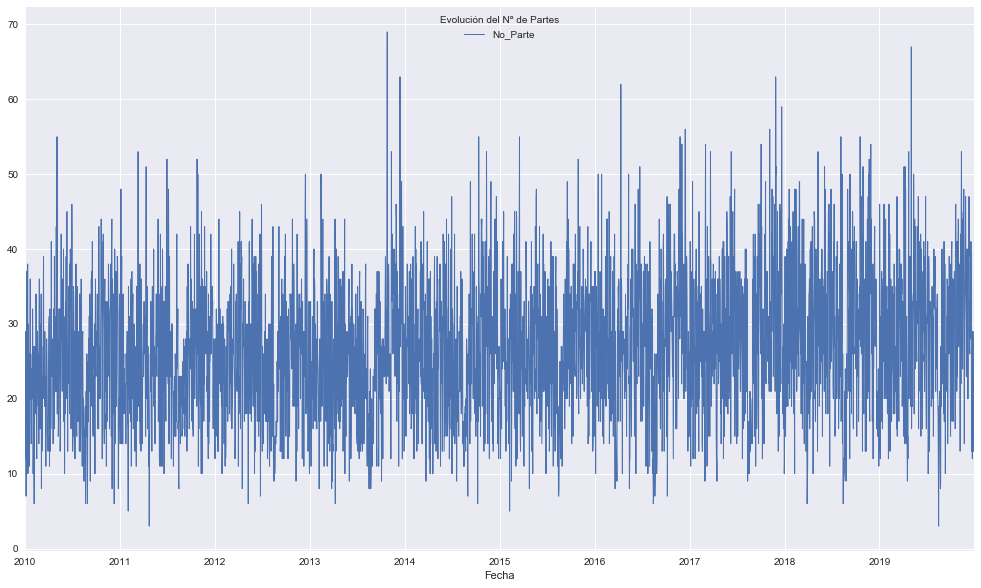

In [4]:
DF_ST = pd.DataFrame(DF.iloc[:,[0,1]])
DF_ST.set_index("Fecha", inplace = True)
DF_ST_Agrupado = DF_ST.groupby('Fecha', as_index=True).agg({"No_Parte": "nunique"})
DF_ST_Agrupado = DF_ST_Agrupado.to_period('D')
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (17,10)
DF_ST_Agrupado.plot(linewidth=1.0)
plt.legend(title= 'Evolución del Nº de Partes', loc='upper center')

Observando el gráfico anterior podemos observar:

- El número de partes va creciendo ligeramente de 2010 a 2018. Dicho crecimiento, podría darse por varias causas, por ejemplo:
    - El registro de accidentes de la base de datos ha mejorado y en años más antiguos - probamente no se tenía registro de todos los accidentes que afectan al patrimonio o tenían heridos.
    - Ha crecido el número de vehículos en circulación en Madrid y por lo tanto, hay más accidentes.
    - Simplemente, han aumentado el número de accidentes. 
 
Por desgracia, con los datos que tenemos en esta BBDD no podemos saber la causa del aumento del número de accidentes.

# Serie Temporal

Es necesario agrupar los No Partes, ya que cada campo con el mismo numero de parte, es informacion de cada uno de los implicados.

In [5]:
DF_ST = pd.DataFrame(DF.iloc[:,[0,1]])
DF_ST.set_index("Fecha", inplace = True)
DF_ST = DF_ST.to_period('M')
DF_ST

,No_Parte
Fecha,
2019-01,2019S000020
2019-01,2019S000017
2019-01,2019S001812
2019-01,2019S001336
2019-01,2019S000028
...,...
2018-12,2019/18
2018-12,2019/18
2018-12,2019/53


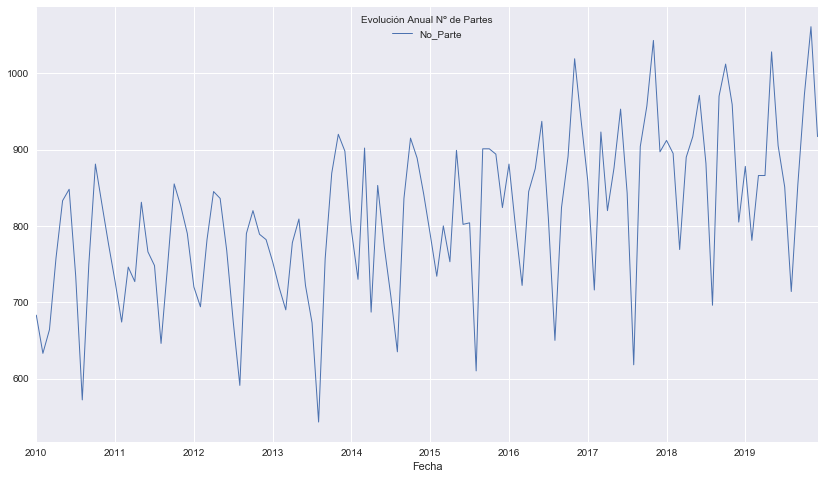

In [6]:
DF_ST_Agrupado = DF_ST.groupby(['Fecha'], as_index=True).agg({"No_Parte": "nunique"})
DF_ST_Agrupado
plt.rcParams["figure.figsize"] = (14,8)
DF_ST_Agrupado.plot(linewidth=1.0);
plt.legend(title= 'Evolución Anual Nº de Partes', loc='upper center')

Vamos a descomponer la serie en tendencia, estacionalidad
y residuos de la serie. Esto ademas de ayudarnos a entender el comportamiento de la serie, nos ayudará a ver si la serie podría tener un comportamiento estacionario o no.Basicamente, veremos si la serie no es estacionaria si:
- Se muestra una tendencia, ya que la media no es constante
- Si hay estacionalidad
- Si la varianza no es constante

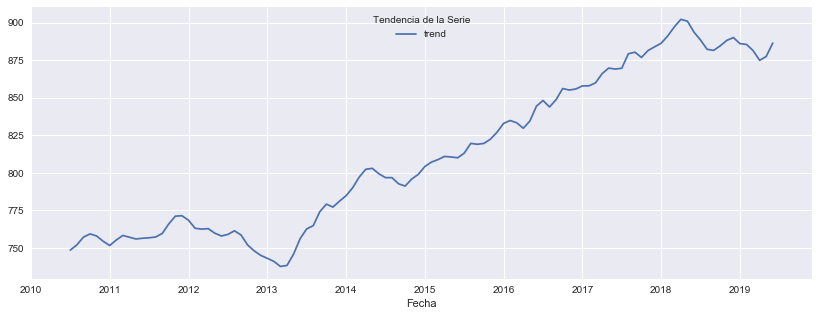

In [7]:
descomposicion = sm.tsa.seasonal_decompose(DF_ST_Agrupado['No_Parte'],freq=12)
plt.rcParams["figure.figsize"] = (14,5)
fig = descomposicion.trend.plot()
plt.legend(title= 'Tendencia de la Serie', loc='upper center')

Observamos que la serie sigue una tendencia creciente, salvo entre 2012 y 2013. 
El hecho de que la serie no tenga una tendencia constante, ya nos dice que la serie no es estacionaria, porque la media no es constante

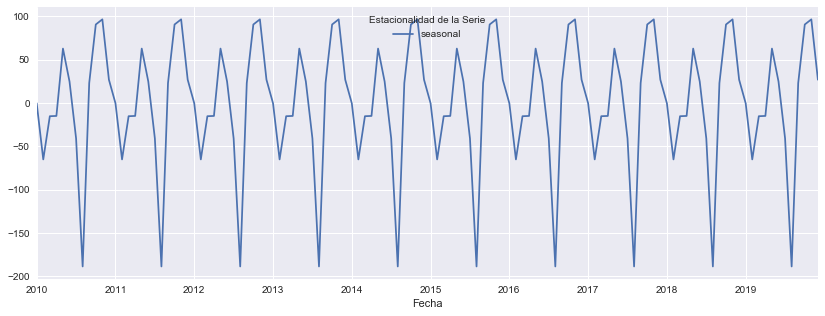

In [8]:
plt.rcParams["figure.figsize"] = (14,5)
fig = descomposicion.seasonal.plot()
plt.legend(title= 'Estacionalidad de la Serie', loc='upper center')

Detectamos muy facilmente que la serie es estacional de manera anual.

## Funcion de autocorrelacion

La función de autocorrelacion, es la autocorrelación entre los valores de las series que se encuentran a k intervalos de distancia. Es decir, como el valor que toma un determinado punto  se ve correlacionado con otro que está en otro punto temporal de la serie. 

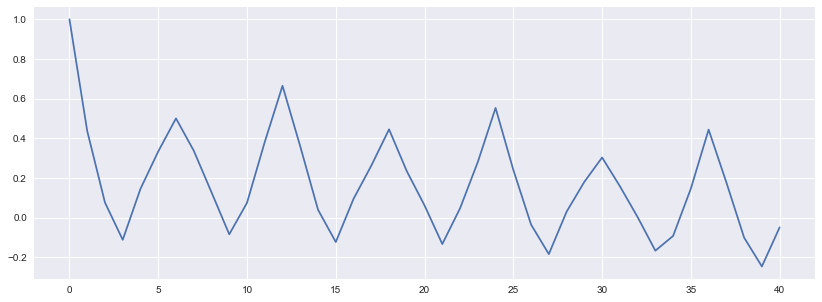

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
acf_results = acf(DF_ST_Agrupado, unbiased = False)
plt.plot(acf_results)

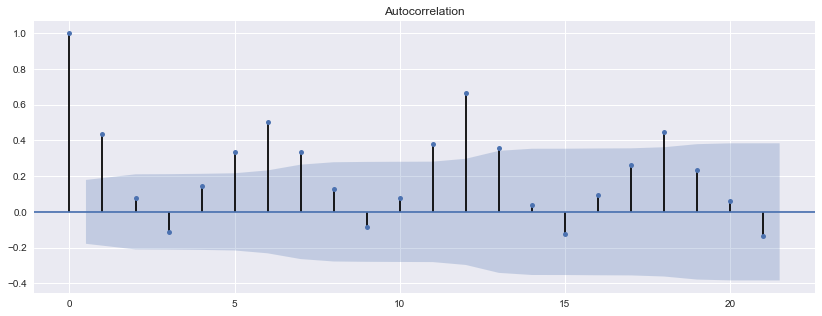

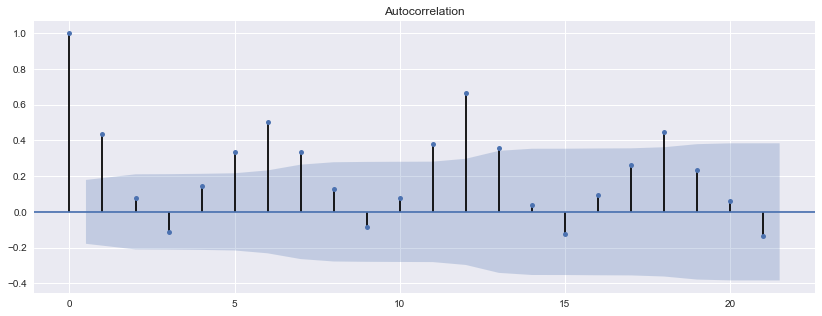

In [10]:
plot_acf(DF_ST_Agrupado, unbiased = False)

Observamos lo siguiente:
    - Podemos observar, que hay un cierto patrón en la autocorrelación, ya que cada aproximadamente 6 periodos la autocorrelación sube. Esto es debido a la estacionalidad que hemos visto anteriormente.   

## La función de autocorrelación parcial (PACF)

El coeficiente de autocorrelación parcial, lo que hace es comparar lags, pero elimina del análisis la relación entre los lags intermedios. Es decir, para analizar la correlación entre el periodo 1 y el periodo 3, no se tiene en cuenta el valor del periodo 2.

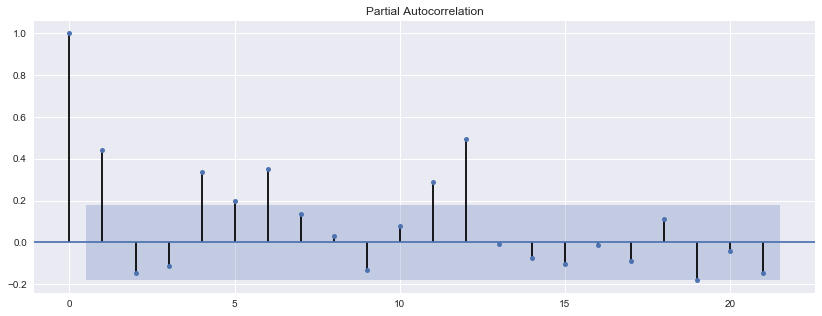

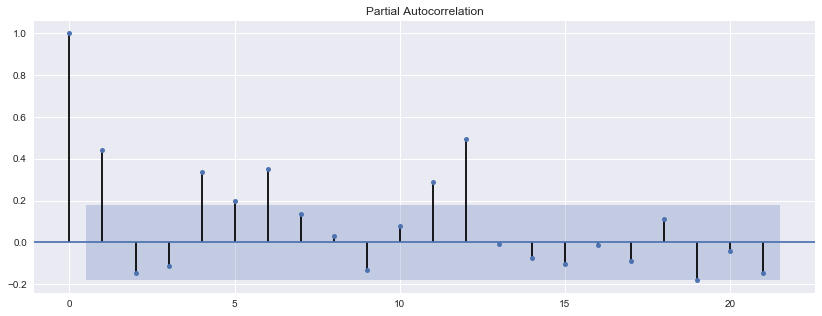

In [11]:
plot_pacf(DF_ST_Agrupado)

Podemos obtener las siguientes conclusiones:
- Se ve claramente un descenso de autocorrelación parcial, según comparamos diferentes lags con intervalo temporal mayor.
- Apreciamos, que cada 6 o 7 meses, la autocorrelación parcial aumenta. Esto indica el comportamiento estacional de la serie.



## Modelos SARIMA

Antes hemos podido intuir que nuestro modelo no es estacionario. No obstante, vamos a probar como seria su predicción. Para ello, vamos a utilizar los modelos SARIMA. Como vimos en clase hay tres tipos de modelos ARIMA:
- Los Autoregresivos - AR(p)
- Los de medias móviles - MA(q)
- Combinación de los dos anteriores - ARMA(p,q)
- Combinación de AR(p) + d (nº de veces que se va a diferenciar la serie) + MA(q)

También tenemos que tener en cuenta que el modelo es estacional y por eso nuestro modelo es SARIMA. Con el fin de saber qué modelo puede predecir de manera más precisa el nº de partes y por lo tanto, accidentes de tráfico. Vamos a utilizar los valores AIC (Akaike Information Criterion) y BIC (Bayesian Information Criterion).



In [12]:
model = pm.auto_arima(
    DF_ST_Agrupado,
    suppress_warnings=True, m = 12
)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -651.643
Date:                            Wed, 26 Aug 2020   AIC                           1315.286
Time:                                    10:35:15   BIC                           1331.960
Sample:                                         0   HQIC                          1322.057
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0137      0.026      0.525      0.600      -0.038       0.065
ar.L1          0.0893      0.095      0.945      0.345      -0.096       0.275
ma.L1         -0.9998      0.265     -3.775      0.000      -1.519      -0.481
ar.S.L12       0.9902      0.019     53.021      0.000       0.954       1.027
ma.S.L12      -0.8099      0.165     -4.898      0.000      -1.134      -0.486
sigma2      2791.9837    866.364      3.223      0.001    1093.942    4490.026
===================================================================================
Ljung-Box (Q):                       33.23   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.77   Prob(JB):                         0.97
Heteroskedasticity (H):               1.78   Skew:                            -0.01
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El modelo que minimizará tanto nuestro AIC como BIC sera el SARIMA(1,1,1)x(1,0,1,12)

In [13]:
mod = SARIMAX(DF_ST_Agrupado.to_timestamp(),trend=None,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12))
model = mod.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           No_Parte   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -653.560
Date:                            Wed, 26 Aug 2020   AIC                           1317.119
Time:                                    10:35:17   BIC                           1331.015
Sample:                                01-01-2010   HQIC                          1322.762
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0488      0.040      1.226      0.220      -0.029       0.127
ma.L1         -0.9374      0.064   

Vamos a ver como predecería nuestro modelo la serie temporal que ya tenemos

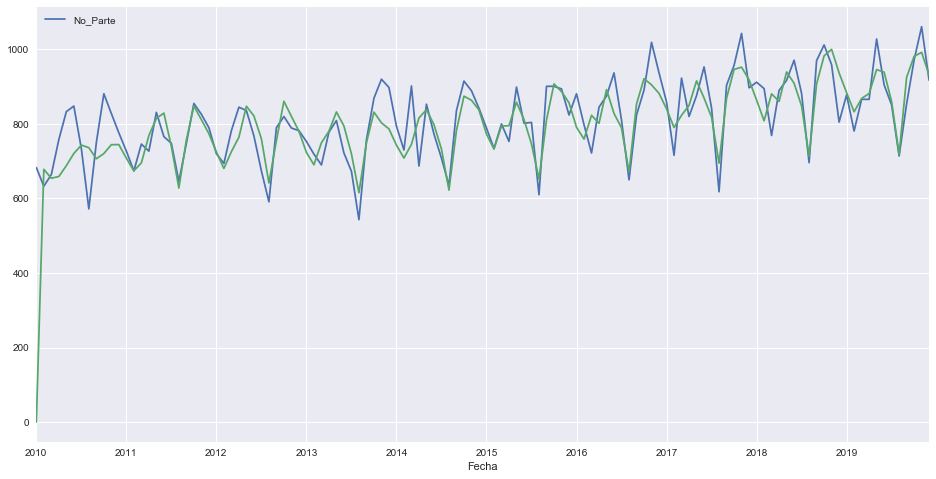

In [14]:
resultados = mod.fit(disp=-1) 
DF_ST_Agrupado[['No_Parte']].plot(figsize=(16, 8))
resultados.fittedvalues.plot(figsize=(16, 8))

Vemos que la predicción es bastante fiable.
A continuación, se hace la predicción del modelo para 60 meses

In [15]:
prediction = model.get_forecast(steps = 60)
lower = prediction.conf_int()["lower No_Parte"]
upper = prediction.conf_int()["upper No_Parte"]
prediction.predicted_mean.head()

2020-01-01    900.735689
2020-02-01    840.275452
2020-03-01    886.268457
2020-04-01    896.431611
2020-05-01    972.895104
Freq: MS, dtype: float64

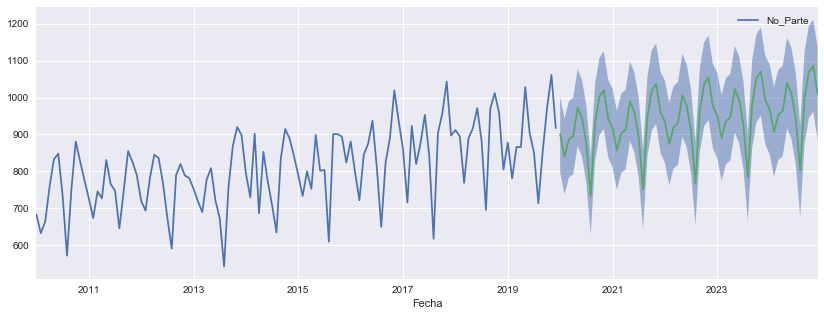

In [16]:
fig, ax = plt.subplots()
DF_ST_Agrupado.plot(ax = ax)
prediction.predicted_mean.plot(ax = ax)
ax.fill_between(lower.index, lower, upper, alpha = 0.5)
plt.show()

No parece que nuestra predicción sea erronea, pero para poder hacer un modelo que sea fiable, necesitamos un modelo estacionario. Es por ello, que vamos a transformar nuestra serie temporal para que sea estacionaria. 

## Transformaciones y Test de Dicky-Fuller

El test de Dicky-Fuller aumentado nos ayudara a confirmar si una serie es estacionaria o no. La hipótesis nula de este test es que la serie temporal no es estacionaria debido a su tendencia.
Este test tiene varios outputs, pero los que mas nos interesan son:
- El primer valor, cuanto mas negativo sea, mas probable será que la serie sea estacionaria.
- El segundo valor, es un p-valor y si el valor, es menos que 0,05 podremos rechazar la hipotesis nula y afirmar que la serie es estacionaria.

Primeramente, haremos el test para la serie temporal sin transformar


In [17]:
adf = adfuller(DF_ST_Agrupado.No_Parte)
adf[0:2]

(-0.23475454828986797, 0.9342501772611815)

### Transformacion 1 - Diferencia con lag anterior

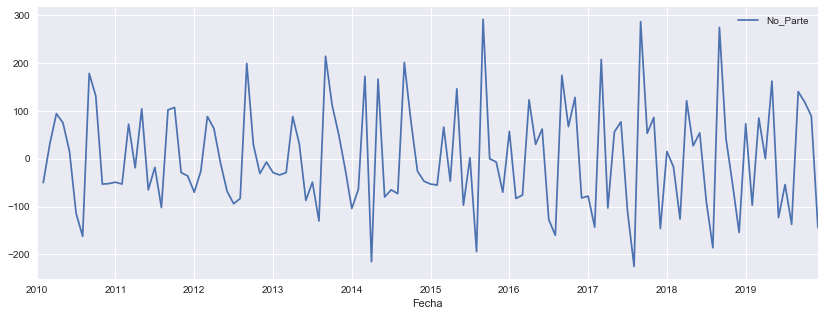

In [18]:
DF_ST_Agrupado_diff = DF_ST_Agrupado - DF_ST_Agrupado.shift(1)
DF_ST_Agrupado_diff['No_Parte'].dropna(inplace = True)
DF_ST_Agrupado_diff.plot();

In [19]:
DF_ST_Agrupado_diff

,No_Parte
Fecha,
2010-01,NaN
2010-02,-50.0
2010-03,31.0
2010-04,94.0
2010-05,75.0
...,...
2019-08,-137.0
2019-09,140.0
2019-10,118.0


In [20]:
adf_diff = adfuller(DF_ST_Agrupado_diff.No_Parte)
adf_diff[0:2]

(-10.034820863616016, 1.5506337727528992e-17)

Si podriamos considerar esta transformación

### Transformacion 2 - Tranformación logaritmica

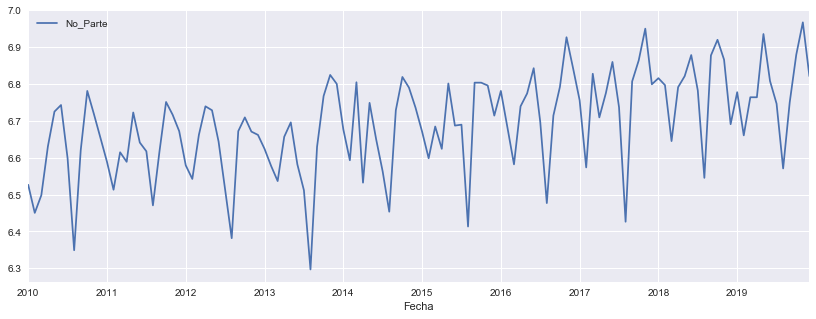

In [21]:
DF_ST_Agrupado_Log = np.log(DF_ST_Agrupado)
DF_ST_Agrupado_Log.dropna(inplace = True)
DF_ST_Agrupado_Log.plot();

In [22]:
adf_Log = adfuller(DF_ST_Agrupado_Log.No_Parte)
adf_Log[0:2]

(-0.3081904228087395, 0.9243362862397478)

No conseguimos que nuestra serie sea estacionaria con esta transformación

### Transformacion 3 - Porcentaje de cambio

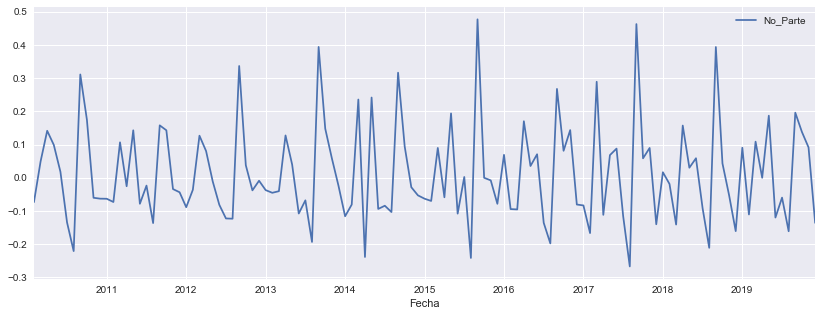

In [23]:
DF_ST_Agrupado_pct = DF_ST_Agrupado.pct_change().dropna()
DF_ST_Agrupado_pct.dropna(inplace = True)
DF_ST_Agrupado_pct.plot();

In [24]:
adf_pct = adfuller(DF_ST_Agrupado_pct.No_Parte)
adf_pct[0:2]

(-3.1019313014391905, 0.026410593279333334)

Si podriamos considerar esta transformación

### Transformacion 4 - Box-Cox

Vamos a probar una ultima transformación, la de Box-Cox. Dichas transformación nos ayudará a corregir la no linealidad de nuestra serie temporal.

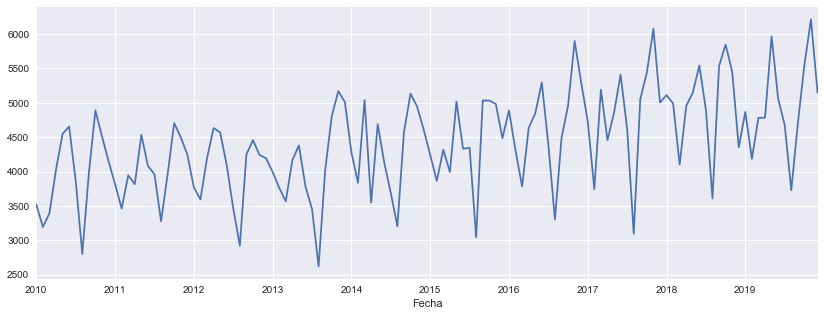

In [25]:
DF_ST_Agrupado['boxcox'], lamda = boxcox(DF_ST_Agrupado.No_Parte)
DF_ST_Agrupado['boxcox'].dropna(inplace = True)
DF_ST_Agrupado['boxcox'].plot();

In [26]:
adf_boxcox = adfuller(DF_ST_Agrupado['boxcox'])
adf_boxcox[0:2]

(-0.21685284958104664, 0.9364827614549864)

In [27]:
DF_ST_Agrupado  = DF_ST_Agrupado.drop('boxcox',axis = 1)

Esta transformación no haria que el modelo fuera estacionario

## Modelo Estacionario

La transformación que hace el modelo mas estacionario,es la de la diferencia con el Lag anterior.

In [28]:
DF_ST_Agrupado_diff = DF_ST_Agrupado_diff.dropna()
DF_ST_Agrupado_diff

,No_Parte
Fecha,
2010-02,-50.0
2010-03,31.0
2010-04,94.0
2010-05,75.0
2010-06,15.0
...,...
2019-08,-137.0
2019-09,140.0
2019-10,118.0


In [29]:
model_diff = pm.auto_arima(
    DF_ST_Agrupado_diff,
    suppress_warnings=True, m = 12
)

model_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  119
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -651.589
Date:                              Wed, 26 Aug 2020   AIC                           1319.177
Time:                                      10:36:14   BIC                           1341.410
Sample:                                           0   HQIC                          1328.205
                                              - 119                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0201      0.056      0.358      0.721      -0.090       0.130
ar.L1         -0.9997      0.003   -356.665      0.000      -1.005      -0.994
ma.L1          0.0591      0.242      0.244      0.807      -0.415       0.533
ma.L2         -0.9982      0.193     -5.173      0.000      -1.376      -0.620
ma.L3         -0.0574      0.104     -0.552      0.581      -0.261       0.146
ar.S.L12       0.9935      0.018     54.249      0.000       0.958       1.029
ma.S.L12      -0.8458      0.205     -4.123      0.000      -1.248      -0.444
sigma2      2825.6036      0.000   1.93e+07      0.000    2825.603    2825.604
===================================================================================
Ljung-Box (Q):                       33.46   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.76   Prob(JB):                         0.94
Heteroskedasticity (H):               1.75   Skew:                             0.00
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.75e+22. Standard errors may be unstable.
"""

In [30]:
model_diff = SARIMAX(DF_ST_Agrupado_diff.to_timestamp(),trend=None,
                                order=(1, 0, 3),
                                seasonal_order=(1, 0, 1, 12)).fit()

Vamos a ver como predecería la serie temporal, la transformacion que se ha calculado:

In [31]:
resultados_diff = SARIMAX(DF_ST_Agrupado_diff.to_timestamp(),trend=None,
                                order=(1, 0, 3),
                                seasonal_order=(1, 0, 1, 12)).fit(disp=-1)

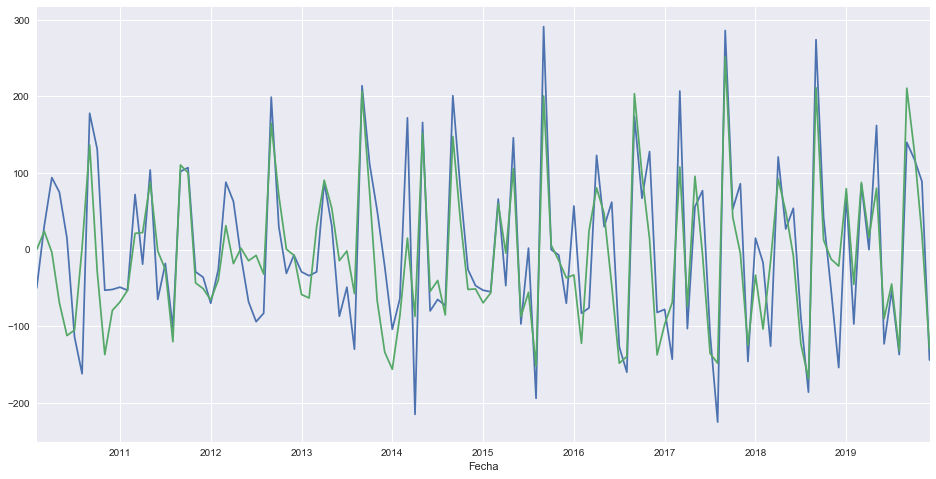

In [32]:
DF_ST_Agrupado_diff['No_Parte'].plot(figsize=(16, 8))
resultados_diff.fittedvalues.plot(figsize=(16, 8))

Observamos que predice, bastante bien la serie temporal

Ahora vemos como predice la serie temporal a futuro de la transformación que hemos hecho

In [33]:
prediction_diff = model_diff.get_forecast(steps = 60)
lower = prediction_diff.conf_int()["lower No_Parte"]
upper = prediction_diff.conf_int()["upper No_Parte"]
prediction_diff.predicted_mean.head()

2020-01-01   -16.720437
2020-02-01   -60.115730
2020-03-01    46.205997
2020-04-01    10.165516
2020-05-01    76.293495
Freq: MS, dtype: float64

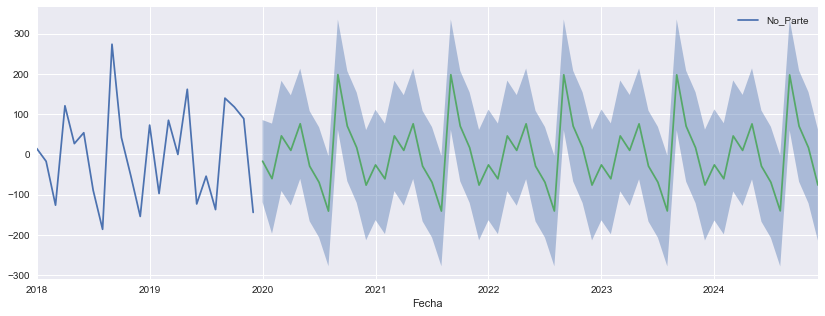

In [34]:
fig, ax = plt.subplots()
DF_ST_Agrupado_diff.truncate(before = "2018").plot(ax = ax)
prediction_diff.predicted_mean.plot(ax = ax)
ax.fill_between(lower.index, lower, upper, alpha = 0.4)
plt.show()

Y por ultimo, hacemos la predicción de nuestra serie temporal inicial. Es decir, hacemos la predicción aplicando la transformacion y despues lo integramos en nuestra serie temporal inicial

In [35]:
np.cumsum(prediction_diff.predicted_mean)
real_prediction = np.cumsum(prediction_diff.predicted_mean) + DF_ST_Agrupado.iloc[-1].values

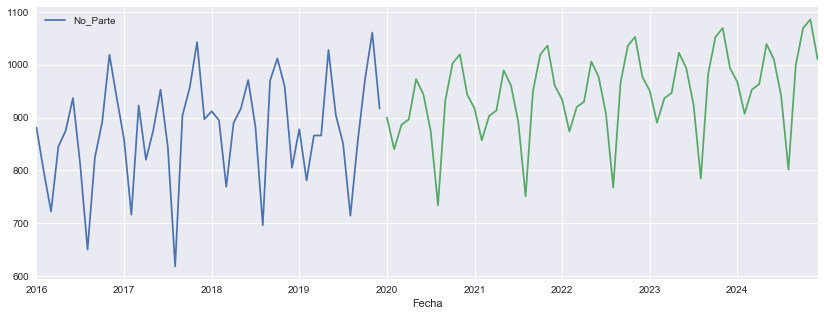

In [36]:
fig, ax = plt.subplots()
DF_ST_Agrupado.truncate(before = "2016").plot(ax = ax)
real_prediction.plot(ax = ax)
plt.show()

## Diagnostico de los errores

Esta es la predicción que obtenemos. Parece a simple vista, la predicción es fiable. No obstante, a continuacion, vamos a analizar el comportamiento de los residuos de cuatro maneras diferentes.

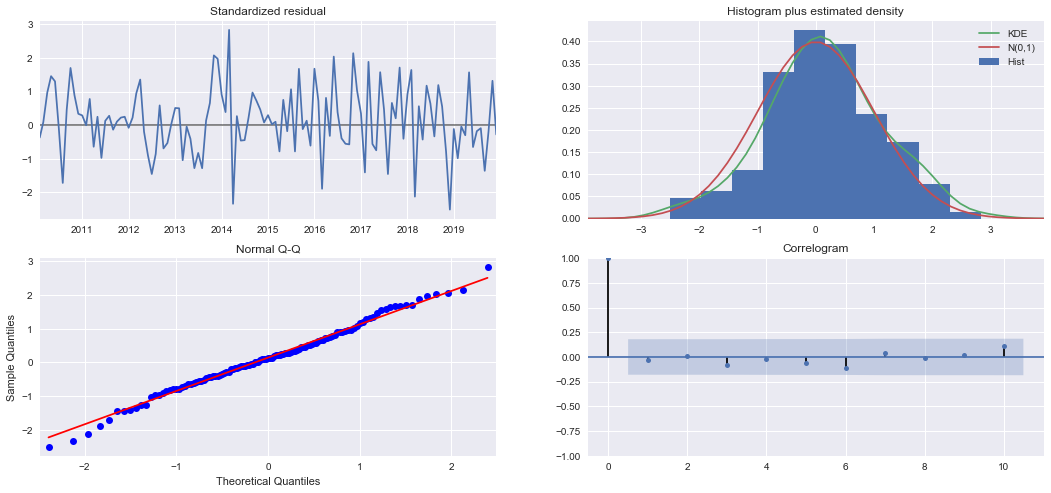

In [37]:
model.plot_diagnostics(figsize=(18, 8))
plt.show()

- En el grafico superior izquierda, a primera vista, no detectamos ninguna estructura, en la distribución de los errores de los siniestros. Cosa que se tiene que cumplir, para que predicción sea válida.
- En el grafico inferior izquierda, si que vemos que los residuos sí que se aproximan a una distribución normal, salvo en los extremos. Esto también implica que tenemos una buena predicción
- En el grafico superior derecha, si que vemos que hay diferencia entre las dos curvas. La curva verde (Kernel Density Estimation) debería estar más próxima a la curva roja que es una normal(0,1).
- En el grafico inferior derecha, vemos un correlograma donde salvo el primer valor, el resto debería quedar por debajo de la línea azul. Ya que eso demuestra que la autocorrelación es cercana a 0 o nula y efectivamente vemos, que eso es lo que ocurre. 

Conclusión: es posible que el modelo sea mejorable, pero según lo visto ahora y las predicciones sí que tenemos un modelo bastante fiable.


# Efecto Covid en la serie temporal

La base de datos de 2020, no se ha tenido en cuenta en el análisis, porque según la fuente de los datos, los datos hasta dentro de unos meses no son definitivos. Ello podría producir que los análisis que fueran a hacerse de la información no fueran fiables.
Sin embargo, en este apartado querremos ver el efecto que ha tenido el confinamiento en marzo, abril y mayo, en el número de accidentes y es por eso que vamos a tratar la info de 2020 para añadirla a la serie temporal, solo con este fin.
El objetivo será comparar lo que se habría predicho en nuestra predicción del modelo de serie temporal hasta justo antes del confinamiento y compararlo con lo que realmente ocurrió con el número de accidentes durante el estado de alarma.
De un primer vistazo, vemos la evolución del número de accidentes sin ilesos, durante el 2020:


Vamos a adaptar primeramente el DataSet de 2020 al formato requerido para tratar la información

In [38]:
pathin = "1. Raw/"
a20 = pd.DataFrame(pd.read_csv(os.path.join(pathin, "2020_Accidentalidad.csv"),sep=";",encoding='latin1'))
a20_ST = a20.iloc[:,[0,1,12]]
a20_ST.rename(columns = {'FECHA':'Fecha','LESIVIDAD*':'Lesividad','Nº  EXPEDIENTE':'No_Parte'},inplace =True)
a20_ST["Lesividad"].replace({1: 1,2: 1,3: 2,4: 3,5: 1,6: 1,7: 1,14: 0,77: 4},inplace=True)
a20_ST["Lesividad"].fillna(0,inplace = True)
a20_ST["Lesividad"] = a20_ST["Lesividad"].astype(np.int64)
a20_ST = a20_ST[a20_ST['Lesividad']>0]
a20_ST= a20_ST.drop('Lesividad', axis = 1)

Agruparemos por fecha de accidente y número de accidentes con el mismo parte. Con el objetivo de ver a continuación graficamente, la evolución del número de accidentes hasta finales de mayo de 2020

In [39]:
a20_ST['Day'], a20_ST['Month'], a20_ST['Year']  = a20_ST['Fecha'].str.split('/', 2).str
a20_ST_Agrupado = a20_ST.groupby(['Day','Month','Year'], as_index=False).agg({"No_Parte": "nunique"})
a20_ST_Agrupado['Fecha']= a20_ST_Agrupado['Day']+a20_ST_Agrupado['Month']+ a20_ST_Agrupado['Year']
a20_ST_Agrupado['Fecha'] = pd.to_datetime(a20_ST_Agrupado['Fecha'],format='%d%m%Y')
a20_ST_Agrupado.drop(['Day','Month','Year'], axis = 1, inplace=True)
a20_ST_Agrupado.set_index("Fecha", inplace = True)

In [40]:
a20_ST['Fecha']= a20_ST['Day']+a20_ST['Month']+ a20_ST['Year']
a20_ST.drop(['Day','Month','Year'], axis = 1, inplace=True)

In [41]:
a20_ST['Fecha'] = pd.to_datetime(a20_ST['Fecha'],format='%d%m%Y')

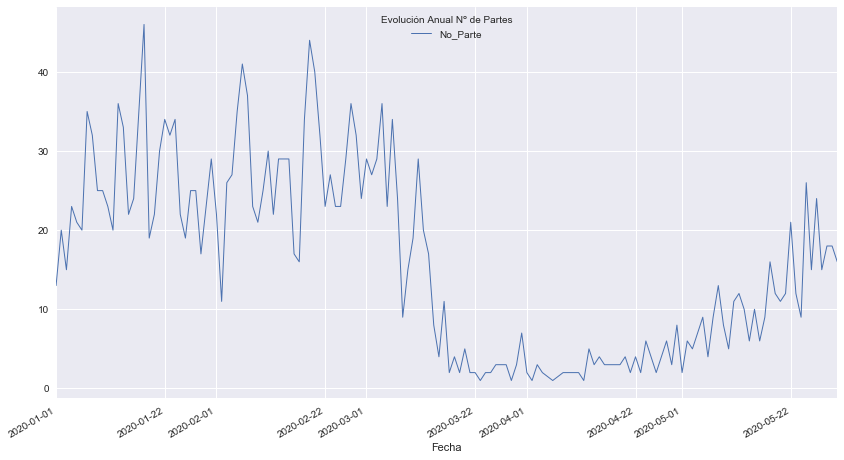

In [42]:
plt.rcParams["figure.figsize"] = (14,8)
a20_ST_Agrupado.plot(linewidth=1.0);
plt.legend(title= 'Evolución Anual Nº de Partes', loc='upper center')

Efectivamente y como se podría esperar, en algún punto entre el 1 de marzo y el 22 de marzo, se ve claramente una bajada en el número de accidentes.

Vamos a separar ahora el DataSet de 2020 en dos:
- Antes o el día 29 de febrero. 
- Después del 1 de marzo

La primera parte la integraremos a la serie del número de accidentes ya utilizada en apartados anteriores. La segunda parte, la compararemos con lo predicho con el modelo de serie temporal que integra todo el evolutivo anterior.
Es cierto y sería lógico, separar el dataset el día 14 de marzo, pero la predicción que se ha hecho en apartados anteriores es mensual y si separamos el mes de marzo en dos partes, la estimación no será correcta porque el acumulado mensual de marzo quedaría incompleto.


In [43]:
a20_ST.set_index("Fecha", inplace = True)
a20_ST_mensual = a20_ST.to_period('M')
a20_ST_mensual.reset_index()

,Fecha,No_Parte
0,2020-01,2020S000038
1,2020-01,2020S000060
2,2020-01,2020S000035
3,2020-01,2020S000073
4,2020-01,2020S000030
...,...,...
2921,2020-05,2020S007605
2922,2020-05,2020S007607
2923,2020-05,2020S007604
2924,2020-05,2020S007559


In [44]:
a20_ST_Agrupado_mensual = a20_ST_mensual.groupby(['Fecha'], as_index=True).agg({"No_Parte": "nunique"})
a20_ST_Agrupado_mensual.reset_index(inplace=True)

In [45]:
a20_ST_Agrupado_mensual

,Fecha,No_Parte
0,2020-01,799
1,2020-02,807
2,2020-03,373
3,2020-04,85
4,2020-05,357


In [46]:
a20_ST_AntesCovid = a20_ST_Agrupado_mensual[a20_ST_Agrupado_mensual['Fecha']<='2020-02']
a20_ST_DespuesCovid = a20_ST_Agrupado_mensual[a20_ST_Agrupado_mensual['Fecha']>'2020-02']
a20_ST_AntesCovid.set_index('Fecha', inplace=True)
a20_ST_DespuesCovid.set_index('Fecha', inplace=True)

In [47]:
DF_ST_Agrupado2 = pd.concat([DF_ST_Agrupado,a20_ST_AntesCovid])

In [48]:
a20_ST_DespuesCovid

,No_Parte
Fecha,
2020-03,373
2020-04,85
2020-05,357


Vamos ahora a hacer la predicción del modelo utilizando datos de la serie hasta finales de febrero de 2020.
Directamente, haremos la transformación que hace que la serie sea estacionaria.

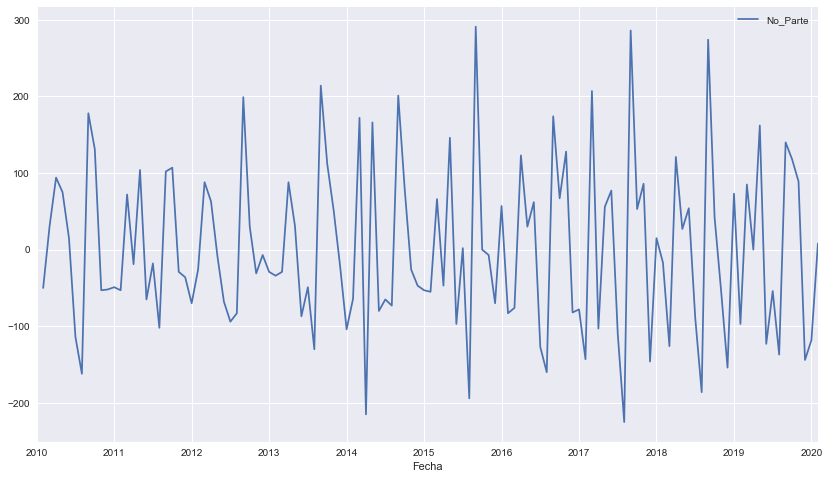

In [49]:
DF_ST_Agrupado_diff2 = DF_ST_Agrupado2 - DF_ST_Agrupado2.shift(1)
DF_ST_Agrupado_diff2['No_Parte'].dropna(inplace = True)
DF_ST_Agrupado_diff2.plot();

Nos cercionamos mediante el test de Dicky Fuller de que haciendo la transformación con la diferencia del Lag anterior, seguiremos obteniendo una serie estacionaria.

In [50]:
adf_diff2 = adfuller(DF_ST_Agrupado_diff2.No_Parte)
adf_diff2[0:2]

(-8.012603304665069, 2.181036645456339e-12)

In [51]:
DF_ST_Agrupado_diff2 = DF_ST_Agrupado_diff2.dropna()
DF_ST_Agrupado_diff2

,No_Parte
Fecha,
2010-02,-50.0
2010-03,31.0
2010-04,94.0
2010-05,75.0
2010-06,15.0
...,...
2019-10,118.0
2019-11,89.0
2019-12,-144.0


Vemos a continuación, que modelo es mas optimo:

In [52]:
model_diff2 = pm.auto_arima(
    DF_ST_Agrupado_diff2,
    suppress_warnings=True, m = 12
)

model_diff2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  121
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -664.185
Date:                            Wed, 26 Aug 2020   AIC                           1340.370
Time:                                    10:37:15   BIC                           1357.145
Sample:                                         0   HQIC                          1347.183
                                            - 121                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0234      0.036      0.658      0.510      -0.046       0.093
ar.L1          0.0774      0.093      0.830      0.406      -0.105       0.260
ma.L1         -0.9992      0.120     -8.302      0.000      -1.235      -0.763
ar.S.L12       0.9830      0.026     37.686      0.000       0.932       1.034
ma.S.L12      -0.7758      0.158     -4.917      0.000      -1.085      -0.467
sigma2      2833.8444    631.812      4.485      0.000    1595.515    4072.173
===================================================================================
Ljung-Box (Q):                       38.61   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.53   Prob(JB):                         0.94
Heteroskedasticity (H):               1.82   Skew:                            -0.01
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
model_diff2 = SARIMAX(DF_ST_Agrupado_diff2.to_timestamp(),trend=None,
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12)).fit()

In [54]:
model_diff2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           No_Parte   No. Observations:                  121
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -665.375
Date:                            Wed, 26 Aug 2020   AIC                           1340.750
Time:                                    10:37:16   BIC                           1354.729
Sample:                                02-01-2010   HQIC                          1346.428
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0564      0.075      0.752      0.452      -0.091       0.204
ma.L1         -0.9344      0.038    -24.885      0.000      -1.008      -0.861
ar.S.L12       0.9967      0.014     72.841      0.000       0.970       1.024
ma.S.L12      -0.8884      0.220     -4.045      0.000      -1.319      -0.458
sigma2      2769.3671    593.328      4.668      0.000    1606.465    3932.269
===================================================================================
Ljung-Box (Q):                       38.42   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.54   Prob(JB):                         0.96
Heteroskedasticity (H):               2.08   Skew:                            -0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Vemos a continuación a ver graficamente la diferencia entre la predicción y lo que realmente ocurrió con el número de accidentes en el confinamiento

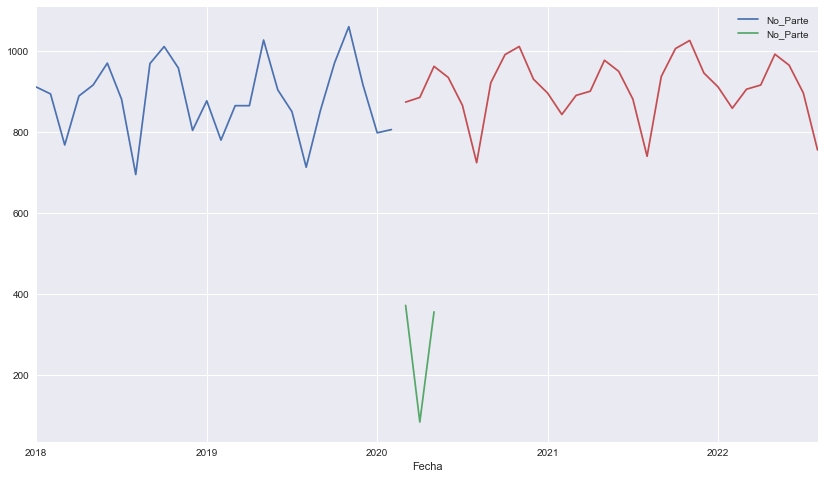

In [55]:
prediction_diff2 = model_diff2.get_forecast(steps = 30)
np.cumsum(prediction_diff2.predicted_mean)
real_prediction2 = np.cumsum(prediction_diff2.predicted_mean) + DF_ST_Agrupado2.iloc[-1].values
fig, ax = plt.subplots()
DF_ST_Agrupado2.truncate(before = "2018").plot(ax = ax)
a20_ST_DespuesCovid.plot(ax = ax)
real_prediction2.plot(ax = ax)
plt.show()

La línea azul, es lo ocurrido hasta febrero de 2020, la línea roja es lo predicho y la línea verde es lo que realmente ocurrió durante el confinamiento.

Solo ha habido tres periodos mensuales de confinamiento que podemos comparar con la predicción que se ha hecho de la serie, pero podemos ver de manera muy clara, que el número de accidentes de tráfico en los meses de confinamiento ha bajado y que como es lógico la predicción no pudo anticipar que esta bajada fuera a ocurrir.

La predicción del número de accidentes hubiera sido bastante acertada, sino hubiera ocurrido el evento Covid. Es por ello, que podemos obtener la siguiente conclusión: los modelos pueden ayudarnos a predecir lo que puede ocurrir, pero no podemos fiarnos ciegamente en ellos. Hay variables que pueden afectar a nuestro modelo y pueden cambiar totalmente nuestra predicción.
